In [1]:
!nvidia-smi

Mon Mar 16 03:12:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:04:00.0 Off |                  N/A |
|  0%   46C    P0    90W / 240W |      0MiB / 11019MiB |     41%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:05:00.0 Off |                  N/A |
| 36%   53C    P0    79W / 240W |      0MiB / 11019MiB |     39%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [ ]:
'''
!pip install neptune-notebooks
!jupyter nbextension enable --py neptune-notebooks
!pip install kaggle
!pip install scikit-multilearn
!pip install iterative-stratification
!pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!apt-get install libsm6 libxrender1 libfontconfig1 -y
!pip install pillow
!pip install pandas
!pip install fastparquet
!pip install pyarrow 
!pip install numpy 
!pip install pip --upgrade
#!pip install python-snappy
#!pip install hyperdash && hyperdash signup
#!pip install tensorflow-gpu --upgrade
!pip install jupyterlab-nvdashboard
#!pip install nvidia-ml-py
!pip install seaborn
!apt-get install nodejs -y
!apt-get install npm -y
!jupyter labextension install jupyterlab-nvdashboard
'''

In [ ]:
'''
!pip install pretrainedmodels
#!pip install pytorch-ignite
!pip install -U git+https://github.com/albu/albumentations
!apt-get install unzip
!pip install neptune-client
!pip install plotly
!apt-get install libglib2.0-0 -y
!pip install git+https://github.com/pytorch/ignite
#!pip install json
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

!pip install torchtoolbox
#!pip install -U git+https://github.com/PistonY/torch-toolbox.git@master
'''

In [9]:
import gc
import os
import warnings
import random
import sys
import math
import json
import argparse
import six
from IPython.core.display import display, HTML
from logging import getLogger
from time import perf_counter
from pathlib import Path
from typing import List
from distutils.util import strtobool

# --- plotly ---

import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import tools, subplots
py.init_notebook_mode(connected=True)

import numpy
import numpy as np 
import pandas as pd
import cv2
from tqdm import tqdm
from numpy.random.mtrand import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.nn.parameter import Parameter
from torch.nn import init, Sequential
from torch.utils.data.dataloader import DataLoader

from ignite.engine.engine import Engine, Events
from ignite.metrics.metric import Metric
from ignite.metrics import Average
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import ModelCheckpoint

#import albumentations
import albumentations as A
#from albumentations.core.transforms_interface import ImageOnlyTransform
from PIL import Image, ImageOps, ImageEnhance
from skimage.transform import AffineTransform, warp
#from autoaugment import ImageNetPolicy

import pretrainedmodels
from torchtoolbox.tools import mixup_data, mixup_criterion


In [10]:
debug=False
submission=False
batch_size=560
device='cuda:0'
out='.'
image_size=128
arch='pretrained'
model_name='se_resnext50_32x4d'
epochs = 150
lr = 0.003
alpha = 0.6

HEIGHT = 137
WIDTH = 236

In [ ]:
from ignite.contrib.handlers.neptune_logger import *

npt_logger = NeptuneLogger(api_token=os.getenv('NEPTUNE_API_TOKEN'),
                           project_name=os.getenv('NEPTUNE_PROJECT'),
                           name='resnet_train',
                           params={'epochs': epochs,
                                   'batch_size': batch_size,
                                   'image_size': '224x224x3',
                                   'threshold': 40.,
                                    'lr': lr})

In [12]:
datadir = Path('.')
outdir = Path('.')

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Read in the data CSV files
train = pd.read_csv(datadir/'train.csv')
train['grapheme'] = le.fit_transform(train['grapheme'])
#del df

# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

In [14]:
train.head(5)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,44
1,Train_1,159,0,0,1248
2,Train_2,22,3,5,103
3,Train_3,53,2,2,888
4,Train_4,71,9,5,438


In [15]:
def prepare_image(datadir, data_type='train',
                  indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']

    image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                      for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [16]:
%%time

#train = pd.read_csv('train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, data_type='train', indices=indices)


image_df_list 4
CPU times: user 1min 52s, sys: 38.2 s, total: 2min 31s
Wall time: 15.7 s


In [17]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [18]:
class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        x = (255 - x).astype(np.float32) / 255.
        #x = cv2.resize(x, (image_size, image_size))
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [19]:
train_dataset = BengaliAIDataset(train_images, train_labels)

In [20]:
image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5 44]


In [21]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image


def resize(image, size=(224, 224), interpolation=cv2.INTER_AREA):
    return cv2.resize(image, size)

In [23]:
import albumentations as A
import numpy as np

def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=False, size=(224, 224),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            x = apply_aug(A.Cutout(num_holes=8, max_h_size =8, max_w_size =8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:

train_transform = Transform(size=(224, 224), affine=False, threshold=40.,
    sigma=-1., blur_ratio=0.0, noise_ratio=0.0, cutout_ratio=0.1,
    grid_distortion_ratio=0.0, random_brightness_ratio=0.0,
    piece_affine_ratio=0., ssr_ratio=0.1)

# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

6it [00:00, 459.41it/s]


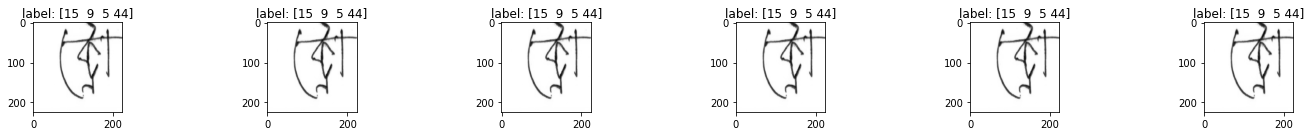

In [25]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

30it [00:00, 591.05it/s]


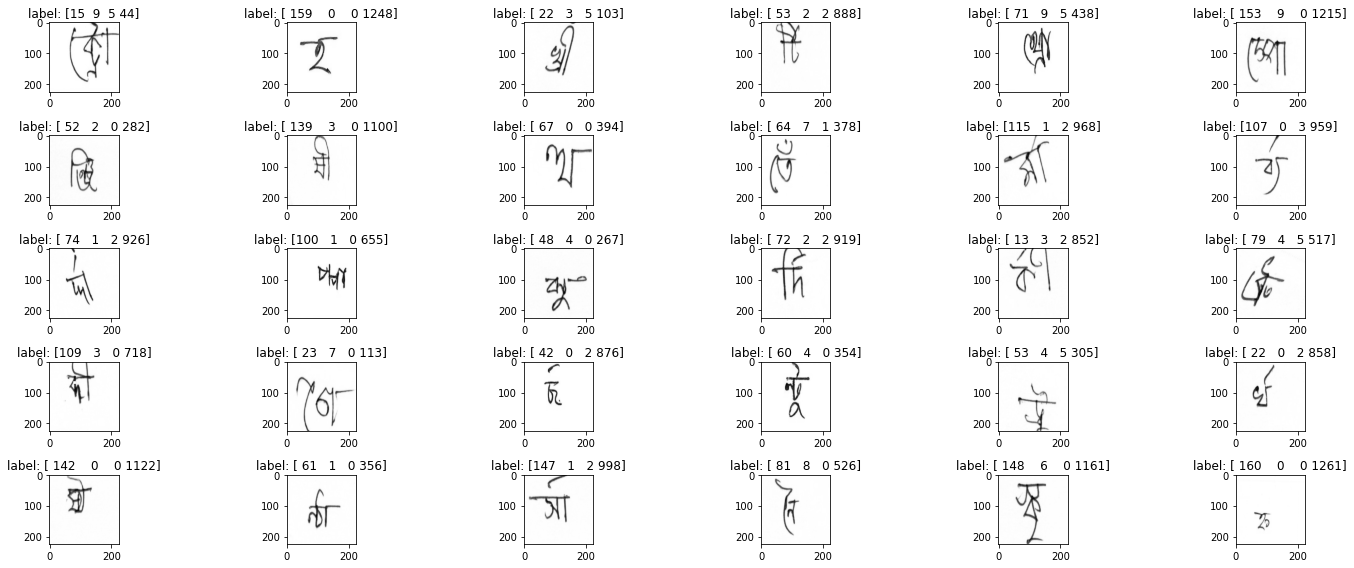

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [27]:
del train_dataset
gc.collect()

0

In [28]:
def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [31]:
class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [32]:
class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        #activation = F.relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = x.repeat(1,3,1,1)
        #h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [33]:

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    return data, targets, shuffled_targets, lam

# loss 
def cutmix_criterion(criterion, preds, targets, shuffled_targets, lam):
    rate=0.7
    return lam * criterion(preds, targets) + (1 - lam) * criterion(preds, shuffled_targets)

def mixup(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    return data, targets, shuffled_targets, lam


def mixup_criterion(criterion, preds, targets, shuffled_targets, lam):
    rate=0.7
    return lam * criterion(preds, targets) + (1 - lam) * criterion(preds, shuffled_targets)


In [34]:
def accuracy(y, y_a, y_b, lam):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = lam * pred_label.eq(y_a.data).cpu().sum().float() + (1 - lam) * pred_label.eq(y_b.data).cpu().sum().float()    
    acc = correct / count
    return acc

def accuracy_val(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc 

def kaggle_metric(y, y_a, y_b, lam):
    pred_label = torch.tensor([], dtype=torch.float32)
    label_a = torch.tensor([], dtype=torch.long)
    label_b = torch.tensor([], dtype=torch.long)

    label_a = y_a
    label_b = y_b

    pred_label = torch.argmax(y, dim=1)
    return (lam * sklearn.metrics.recall_score(label_a, pred_label, average='macro') 
            + (1 - lam) * sklearn.metrics.recall_score(label_b, pred_label, average='macro'))


def kaggle_metric_val(y, t):
    pred_label = torch.tensor([], dtype=torch.float32)
    label = torch.tensor([], dtype=torch.long)
    label = t
    pred_label = torch.argmax(y, dim=1)
    return sklearn.metrics.recall_score(label, pred_label, average='macro')

criterion = nn.CrossEntropyLoss(reduction='mean')



In [35]:
class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7, n_root=1295):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_root = n_root
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant + self.n_root
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall_grapheme', 'recall_vowel', 'recall_consonant', 'recall_root']

    def forward(self, x, y, y_a=None, y_b=None, lam=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 4
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant, self.n_root], dim=1)
        if np.random.rand()<0.5:    
            loss_grapheme = cutmix_criterion(criterion, preds[0], y_a[:, 0], y_b[:, 0], lam)
            loss_vowel = cutmix_criterion(criterion, preds[1], y_a[:, 1], y_b[:, 1], lam)
            loss_consonant = cutmix_criterion(criterion, preds[2], y_a[:, 2], y_b[:, 2], lam)
            loss_root = cutmix_criterion(criterion, preds[3], y_a[:, 3], y_b[:, 3], lam)
            
            loss = loss_grapheme + loss_vowel + loss_consonant + loss_root
            metrics = {
                'loss': loss.item(),
                'loss_grapheme': loss_grapheme.item(),
                'loss_vowel': loss_vowel.item(),
                'loss_consonant': loss_consonant.item(),
                'acc_grapheme': accuracy(preds[0], y_a[:, 0], y_b[:, 0], lam),
                'acc_vowel': accuracy(preds[1], y_a[:, 1], y_b[:, 1], lam),
                'acc_consonant': accuracy(preds[2], y_a[:, 2], y_b[:, 2], lam),
                'recall_grapheme': kaggle_metric(preds[0].cpu(), y_a[:, 0].cpu().numpy(), y_b[:, 0].cpu().numpy(), lam),
                'recall_vowel': kaggle_metric(preds[1].cpu(), y_a[:, 1].cpu().numpy(), y_b[:, 1].cpu().numpy(), lam),
                'recall_consonant': kaggle_metric(preds[2].cpu(), y_a[:, 2].cpu().numpy(), y_b[:, 2].cpu().numpy(), lam),
                'recall_root': kaggle_metric(preds[3].cpu(), y_a[:, 3].cpu().numpy(), y_b[:, 3].cpu().numpy(), lam),
            }
            return loss, metrics, pred
        else:
            loss_grapheme = criterion(preds[0], y[:, 0])
            loss_vowel = criterion(preds[1], y[:, 1])
            loss_consonant = criterion(preds[2], y[:, 2])            
            loss_root = criterion(preds[3], y[:, 3])
            loss = loss_grapheme + loss_vowel + loss_consonant + loss_root
            
            metrics = {
                'loss': loss.item(),
                'loss_grapheme': loss_grapheme.item(),
                'loss_vowel': loss_vowel.item(),
                'loss_consonant': loss_consonant.item(),
                'acc_grapheme': accuracy_val(preds[0], y[:, 0]),
                'acc_vowel': accuracy_val(preds[1], y[:, 1]),
                'acc_consonant': accuracy_val(preds[2], y[:, 2]),
                'recall_grapheme': kaggle_metric_val(preds[0].cpu(), y[:, 0].cpu().numpy()),
                'recall_vowel': kaggle_metric_val(preds[1].cpu(), y[:, 1].cpu().numpy()),
                'recall_consonant': kaggle_metric_val(preds[2].cpu(), y[:, 2].cpu().numpy()),
                'recall_root':kaggle_metric_val(preds[3].cpu(), y[:, 3].cpu().numpy()),
            }
            return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant, self.n_root], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [36]:
class BengaliClassifierVal(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7, n_root=1295):
        super(BengaliClassifierVal, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_root = n_root
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant + self.n_root
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall_grapheme', 'recall_vowel', 'recall_consonant', 'recall_root']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 4
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant, self.n_root], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss_root = criterion(preds[3], y[:, 3])
        loss = loss_grapheme + loss_vowel + loss_consonant + loss_root
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy_val(preds[0], y[:, 0]),
            'acc_vowel': accuracy_val(preds[1], y[:, 1]),
            'acc_consonant': accuracy_val(preds[2], y[:, 2]),
            'recall_grapheme': kaggle_metric_val(preds[0].cpu(), y[:, 0].cpu().numpy()),
            'recall_vowel': kaggle_metric_val(preds[1].cpu(), y[:, 1].cpu().numpy()),
            'recall_consonant': kaggle_metric_val(preds[2].cpu(), y[:, 2].cpu().numpy()),
            'recall_root':kaggle_metric_val(preds[3].cpu(), y[:, 3].cpu().numpy()),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant, self.n_root], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

In [37]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.85)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)

train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices=perm[:train_data_size])

valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(224, 224)),
    indices=perm[train_data_size:train_data_size+valid_data_size])

print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 170714 valid_dataset 30126


In [ ]:
'''
n_dataset = len(train_images)

train_data_size, valid_data_size= train_test_split(
np.arange(n_dataset),
test_size=0.2,
shuffle=True,
stratify=train_labels)

train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices=train_data_size)

valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(policy=False, affine=False, crop=False, size=(137, 236)),
    indices=valid_data_size)
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
'''

In [39]:
class WrappedModel(nn.Module):
    def __init__(self, module):
        super(WrappedModel, self).__init__()
        self.module = module # that I actually define.
    def forward(self, x):
        return self.module(x)

In [40]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_root = 1295
n_total = n_grapheme + n_vowel + n_consonant + n_root
print('n_total', n_total)

predictor = PretrainedCNN(in_channels=3, out_dim=n_total, model_name=model_name, pretrained='imagenet')
#predictor = WrappedModel(predictor)
#load_checkpoint = torch.load('checkpoint.pt')
#predictor.load_state_dict(load_checkpoint['state_dict'])
#predictor = torch.load('checkpoint.pt')
print('predictor', type(predictor))

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  predictor = nn.DataParallel(predictor)

classifier = BengaliClassifier(predictor).to(device)
classifier_val = BengaliClassifierVal(predictor).to(device)

n_total 1481
predictor <class '__main__.PretrainedCNN'>
Let's use 8 GPUs!


In [41]:
def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

In [42]:
class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()
        x, y = [elem.to(device) for elem in batch]
        x, y_a, y_b, lam = cutmix(x, y, alpha)
        loss, metrics, pred_y = classifier(x, y, y_a, y_b, lam)
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    trainer = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            x, y = [elem.to(device) for elem in batch]
            _, metrics, pred_y = classifier(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath='model/model_{count:03}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            checkpoint = {
            'epoch': engine.state.epoch,
            'state_dict': predictor.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()    
            }
            torch.save(checkpoint, 'checkpoint.pt')
            # self.logger.warning(f'save model to {filepath}...')


In [43]:
class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float32)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


In [44]:
def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7, n_root=1295):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant, n_root], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
           f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [45]:
# Store the best model
def default_score_fn(engine):
    score = engine.state.metrics['recall']
    return score

best_model_handler = ModelCheckpoint(dirname='best_models/',
                                     filename_prefix="best",
                                     n_saved=5,
                                     score_name="recall",
                                     score_function=default_score_fn,
                                     require_empty=False)

In [46]:
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=15)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=15)

optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)#0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-6)

#optimizer.load_state_dict(load_checkpoint['optimizer'])
#scheduler.load_state_dict(load_checkpoint['scheduler_state_dict'])
#epoch = load_checkpoint['epoch']

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()

EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

#pbar = ProgressBar()
#pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier_val, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
#trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    #best_model_handler, {'model': predictor, })
    ModelSnapshotHandler(predictor))
    
#evaluator.add_event_handler(
#    Events.COMPLETED,
#    best_model_handler, {'model': predictor, })
    #ModelSnapshotHandler(predictor, filepath='model.pt'))



In [47]:
#to_save = {'model': predictor, 'optimizer': optimizer, 'lr_scheduler': scheduler, 'trainer': trainer}
#handler = Checkpoint(to_save, DiskSaver('tmp/models', create_dir=True), n_saved=5)
#trainer.add_event_handler(Events.EPOCH_COMPLETED, handler)

In [48]:
npt_logger.attach(trainer,
                  log_handler=OutputHandler(tag="training",
                                            output_transform=lambda loss: {'batchloss': loss},
                                            metric_names='all'),
                  event_name=Events.ITERATION_COMPLETED(every=100))

npt_logger.attach(evaluator,
                  log_handler=OutputHandler(tag="validation",
                                            metric_names='all',
                                            another_engine=trainer),
                  event_name=Events.EPOCH_COMPLETED)

npt_logger.attach(trainer,
                  log_handler=OptimizerParamsHandler(optimizer),
                  event_name=Events.ITERATION_COMPLETED(every=100))


In [ ]:
trainer.run(train_loader, max_epochs=epochs)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



recall: grapheme 0.0029940119760479044, vowel 0.09677336466156343, consonant 0.1326629399909805, total 0.058856082151159936, y (560, 4)


/opt/conda/lib/python3.7/site-packages/ignite/contrib/handlers/neptune_logger.py:143: UserWarning:

NeptuneLogger output_handler can not log metrics value type <class 'tuple'>



recall: grapheme 0.14708080963308254, vowel 0.48856638305685424, consonant 0.43086227875401695, total 0.30339757026925906, y (170714, 4)
recall: grapheme 0.541746066349451, vowel 0.908193551504073, consonant 0.8180856116845082, total 0.7024428239718709, y (560, 4)
recall: grapheme 0.701432156563332, vowel 0.915087100309128, consonant 0.9510730131153036, total 0.8172561066377739, y (30126, 4)
recall: grapheme 0.06754436446759987, vowel 0.36113526083363356, consonant 0.4085323307666361, total 0.22618908013386735, y (560, 4)
recall: grapheme 0.41063136968776925, vowel 0.5924178768690049, consonant 0.6920780426067406, total 0.526439664712821, y (170714, 4)
recall: grapheme 0.578147454335703, vowel 0.8904262555684894, consonant 0.9426354418268165, total 0.747339151516678, y (560, 4)
recall: grapheme 0.7439737317151447, vowel 0.8818907279546614, consonant 0.9411856658026585, total 0.8277559642969023, y (30126, 4)
recall: grapheme 0.7053515034637553, vowel 0.9366022834947806, consonant 0.9273

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history
    
npt_logger.experiment.log_artifact(outdir / 'log.csv')

In [ ]:
npt_logger.close()